In [1]:
import pandas as pd
import numpy as np

In [2]:
from glob import glob
from pprint import pprint
import dill
import json

In [3]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.layouts import gridplot
import bokeh.palettes as bpal
from bokeh.models import CategoricalColorMapper
from bokeh.transform import factor_cmap, linear_cmap
from bokeh.models import Legend, LinearAxis, Range1d, DatetimeTickFormatter
from bokeh.io import export_png
output_notebook()

import matplotlib.pyplot as plt
%matplotlib inline

Loading BokehJS ...

In [4]:
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from pmdarima import auto_arima
from sklearn.preprocessing import StandardScaler

In [5]:
def make_plotgrid(totalrange, ncols):
    """for feeding into bokeh griplot, returns array of rows/columns"""
    nrows = int(np.ceil(totalrange/ncols))
    feeder = iter(range(totalrange))
    plotgrid = [[]]*nrows
    for r in range(nrows):
        thisrow = []
        for c in range(ncols):
            try:
                thisrow.append(next(feeder))
            except:
                thisrow.append(None)
        plotgrid[r] = thisrow
    return plotgrid

In [6]:
def draw_gridplot(indf, columns='first', ncols=3, total_width=900, each_height=300, incolours = ['blue','red','yellow','green','purple','orange']):
    """Grid plots by month in bokeh
    Requires:
    > indf has datetime index
    > if columns are left unspecified (should be a list of col names), then just first column is plotted
    > only takes up to 6 columns, then runs out of colours to plot unless you put more into incolours"""
    if columns == 'first':
        columns = [indf.columns[0]]
    else:
        pass
    indf['Month'] = indf.index.month
    indf['mthname'] = indf.index.month_name()
    
    each_width = int(total_width/ncols)
    
    clrcols = [(col, clr) for col, clr in zip(columns, incolours)]
    dictmonth = {}
    
    for no,mth in enumerate(indf.mthname.unique()):
        dictmonth[no] = figure(plot_width=each_width, plot_height=each_height, title=mth, x_axis_type='datetime')
        for col, clr in clrcols:
            dictmonth[no].line(indf.index[indf.Month == no+1], indf[col][indf.Month == no+1], line_width=1, color = clr)
    
    plotgrid = make_plotgrid(len(indf.mthname.unique()), ncols=ncols)
    for row in range(len(plotgrid)):
        for p in range(len(plotgrid[row])):
            plotgrid[row][p] = dictmonth[plotgrid[row][p]]
    
    the_grid = gridplot(plotgrid)
    show(the_grid)
    return the_grid

In [7]:
feat_files = glob('../data/ready-for-model/*.csv')
feat_files

['../data/ready-for-model/20190809_QLDdf_interpolated_features.csv',
 '../data/ready-for-model/2009-18_NEMtotaldemand.csv',
 '../data/ready-for-model/20190809_SAdf_interpolated_features.csv',
 '../data/ready-for-model/20190226_SAdf_features.csv',
 '../data/ready-for-model/20190226_TASdf_features.csv',
 '../data/ready-for-model/20190809_NSWdf_interpolated_features.csv',
 '../data/ready-for-model/20190226_NSWdf_features.csv',
 '../data/ready-for-model/20190226_VICdf_features.csv',
 '../data/ready-for-model/20190809_TASdf_interpolated_features.csv',
 '../data/ready-for-model/20190226_QLDdf_features.csv',
 '../data/ready-for-model/20190809_VICdf_interpolated_features.csv']

In [8]:
fvic = glob('../data/ready-for-model/*VIC*interp*.csv')[0]
fvic

'../data/ready-for-model/20190809_VICdf_interpolated_features.csv'

In [9]:
ftarget = feat_files = glob('../data/ready-for-model/*NEM*.csv')[0]
ftarget

'../data/ready-for-model/2009-18_NEMtotaldemand.csv'

In [10]:
dftarget = pd.read_csv(ftarget, index_col=0, parse_dates=[0])
dftarget.head(3)

,NSW1,QLD1,SA1,TAS1,VIC1,NEMtotal
SETTLEMENTDATE,,,,,,
2009-01-01 00:30:00,7535.00,5611.54,1310.89,909.71,4799.87,20167.01
2009-01-01 01:00:00,7229.24,5457.34,1272.69,896.63,4646.21,19502.11
2009-01-01 01:30:00,6857.62,5294.12,1178.87,897.52,4950.16,19178.29


### Setting target variable as the electricity demand ('VIC1') up to (& including) year 2018

In [11]:
target = dftarget[['VIC1']][dftarget.index.year != 2019]
target = target.asfreq('30T')
target.head(3)

,VIC1
SETTLEMENTDATE,
2009-01-01 00:30:00,4799.87
2009-01-01 01:00:00,4646.21
2009-01-01 01:30:00,4950.16


In [12]:
target.isnull().sum()

VIC1    1
dtype: int64

<font color = 'purple'><br>
### dfvic contains all independent variable data, on matching timescale

In [13]:
dfvic = pd.read_csv(fvic, index_col=0, parse_dates=[0])
dfvic = dfvic.asfreq('30T')
dfvic.head(2)

,Date,Hour_of_day,Year,shoulder,summer,winter,workdayVIC,MILDURA-AIRPORT_MinT_76031,CAPE-NELSON_MaxT_90184,MORWELL_MaxT_85280,MELBOURNE-AIRPORT_MinT_86282,CAPE-NELSON_MinT_90184,MILDURA-AIRPORT_MaxT_76031,MELBOURNE-AIRPORT_MaxT_86282,MORWELL_MinT_85280
SETTLEMENTDATE,,,,,,,,,,,,,,,
2009-01-01 00:30:00,2009-01-01,0.5,2009.0,0.0,1.0,0.0,0.0,13.8,15.9,20.1,11.2,12.7,27.4,19.9,9.4
2009-01-01 01:00:00,2009-01-01,1.0,2009.0,0.0,1.0,0.0,0.0,13.8,15.9,20.1,11.2,12.7,27.4,19.9,9.4


In [14]:
dfvic.tail(2)

,Date,Hour_of_day,Year,shoulder,summer,winter,workdayVIC,MILDURA-AIRPORT_MinT_76031,CAPE-NELSON_MaxT_90184,MORWELL_MaxT_85280,MELBOURNE-AIRPORT_MinT_86282,CAPE-NELSON_MinT_90184,MILDURA-AIRPORT_MaxT_76031,MELBOURNE-AIRPORT_MaxT_86282,MORWELL_MinT_85280
SETTLEMENTDATE,,,,,,,,,,,,,,,
2018-12-31 23:00:00,2018-12-31,23.0,2018.0,0.0,1.0,0.0,1.0,21.3,21.4,31.4,15.8,14.9,36.5,25.4,17.1
2018-12-31 23:30:00,2018-12-31,23.5,2018.0,0.0,1.0,0.0,1.0,21.3,21.4,31.4,15.8,14.9,36.5,25.4,17.1


In [15]:
dfvic.isnull().sum()

Date                            0
Hour_of_day                     0
Year                            0
shoulder                        0
summer                          0
winter                          0
workdayVIC                      0
MILDURA-AIRPORT_MinT_76031      0
CAPE-NELSON_MaxT_90184          0
MORWELL_MaxT_85280              0
MELBOURNE-AIRPORT_MinT_86282    0
CAPE-NELSON_MinT_90184          0
MILDURA-AIRPORT_MaxT_76031      0
MELBOURNE-AIRPORT_MaxT_86282    0
MORWELL_MinT_85280              0
dtype: int64

<font color = 'purple'><br>
### dfmerged will contain both the target variable and all independent variables 2009 - 2018

In [16]:
dfmerged = pd.merge(dfvic, target, how='left', left_index=True, right_index=True)
dfmerged.dropna(inplace=True)  # this should only get rid of last row, first half hour of 2019 with some NaN values
dfmerged.head(3)

,Date,Hour_of_day,Year,shoulder,summer,winter,workdayVIC,MILDURA-AIRPORT_MinT_76031,CAPE-NELSON_MaxT_90184,MORWELL_MaxT_85280,MELBOURNE-AIRPORT_MinT_86282,CAPE-NELSON_MinT_90184,MILDURA-AIRPORT_MaxT_76031,MELBOURNE-AIRPORT_MaxT_86282,MORWELL_MinT_85280,VIC1
SETTLEMENTDATE,,,,,,,,,,,,,,,,
2009-01-01 00:30:00,2009-01-01,0.5,2009.0,0.0,1.0,0.0,0.0,13.8,15.9,20.1,11.2,12.7,27.4,19.9,9.4,4799.87
2009-01-01 01:00:00,2009-01-01,1.0,2009.0,0.0,1.0,0.0,0.0,13.8,15.9,20.1,11.2,12.7,27.4,19.9,9.4,4646.21
2009-01-01 01:30:00,2009-01-01,1.5,2009.0,0.0,1.0,0.0,0.0,13.8,15.9,20.1,11.2,12.7,27.4,19.9,9.4,4950.16


In [17]:
target = dfmerged[['VIC1']].copy()
target = target.asfreq('30T')
print(target.index.freq)
target.isnull().any(axis=1).sum()

<30 * Minutes>


1

<Figure size 432x288 with 0 Axes>

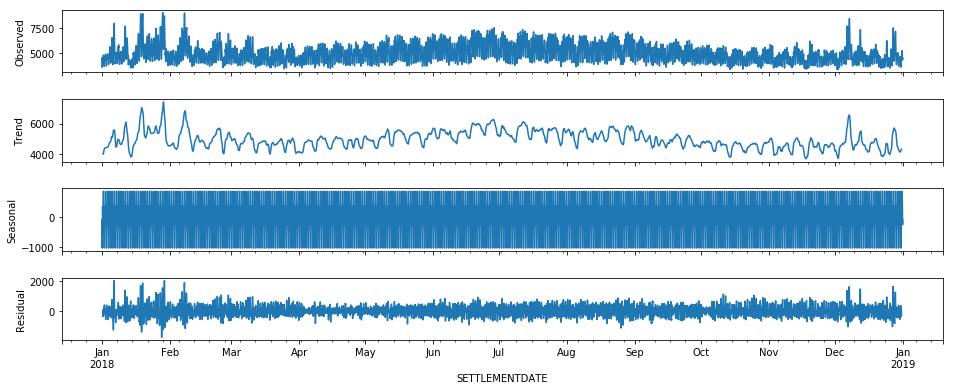

In [18]:
daily = seasonal_decompose(target.VIC1[target.index.year == 2018], freq = 48)
fig = plt.figure()  
fig = daily.plot()  
fig.set_size_inches(15, 6)
plt.show()

<Figure size 432x288 with 0 Axes>

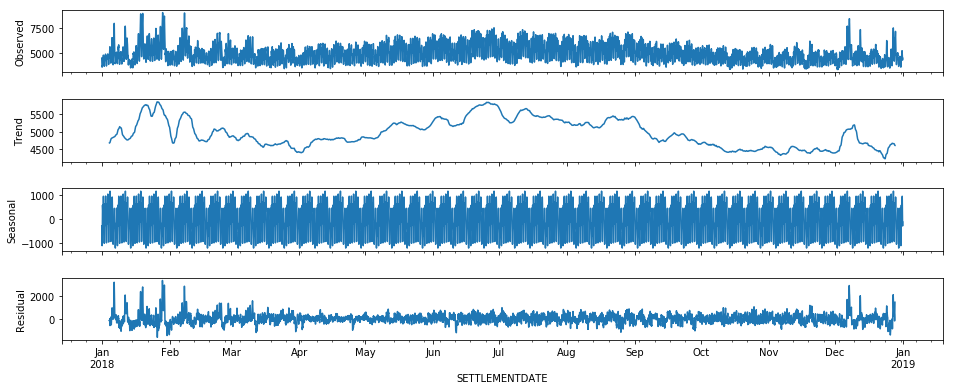

In [19]:
weekly = seasonal_decompose(target.VIC1[target.index.year == 2018], freq = 48*7)
fig = plt.figure()  
fig = weekly.plot()  
fig.set_size_inches(15, 6)

In [20]:
# def stacked(df):
#     df_top = df.cumsum(axis=1)
#     df_bottom = df_top.shift(axis=1).fillna({'y0': 0})[::-1]
#     df_stack = pd.concat([df_bottom, df_top], ignore_index=True)
#     return df_stack

<font color = 'purple'><i>
### This was just for creating graphs for a powerpoint presentation

In [21]:
dtformats = DatetimeTickFormatter(microseconds = ['%fus'],
milliseconds = ['%3Nms', '%S.%3Ns'],
seconds = ['%Ss'],
minsec = [':%M:%S'],
minutes = [':%M', '%Mm'],
hourmin = ['%H:%M'],
hours = ['%Hh', '%H:%M'],
days = ['%d/%m', '%a%d'],
months = ['%m/%Y', '%b %Y'],
years = ['%Y'])

In [22]:
v = figure(plot_height = 400, plot_width = 850, x_axis_type = 'datetime')

v.extra_y_ranges = {'temp' : Range1d(start=0, end=45)}
v.xaxis.formatter = dtformats
v.add_layout(LinearAxis(y_range_name='temp'), 'right')
v.line(target.index, target.VIC1, color = 'purple')
v.line(target.index, dfvic['MELBOURNE-AIRPORT_MaxT_86282'][dfvic.index.isin(target.index)], color = 'orange', y_range_name='temp')
v.line(target.index, dfvic['MELBOURNE-AIRPORT_MinT_86282'][dfvic.index.isin(target.index)], color = 'aqua', y_range_name='temp')
v.vbar(target.index - pd.to_timedelta(15, unit='m'), width=pd.to_timedelta(30, unit='m'), 
       top=dfvic['workdayVIC'][dfvic.index.isin(target.index)]*100, fill_alpha=0.3, fill_color = 'green', 
       line_alpha=0, y_range_name='temp')

# show(v)

GlyphRenderer(id='1058', ...)

<font color = 'purple'><br>
### Creating StandardScaled set of exogenous features

In [23]:
vfeatures = dfvic[dfvic.index.isin(target.index)].drop(columns=['Date','Year','Hour_of_day']).copy()
vfeatures = vfeatures.asfreq('30T')
vfeatures.head(3)

,shoulder,summer,winter,workdayVIC,MILDURA-AIRPORT_MinT_76031,CAPE-NELSON_MaxT_90184,MORWELL_MaxT_85280,MELBOURNE-AIRPORT_MinT_86282,CAPE-NELSON_MinT_90184,MILDURA-AIRPORT_MaxT_76031,MELBOURNE-AIRPORT_MaxT_86282,MORWELL_MinT_85280
SETTLEMENTDATE,,,,,,,,,,,,
2009-01-01 00:30:00,0.0,1.0,0.0,0.0,13.8,15.9,20.1,11.2,12.7,27.4,19.9,9.4
2009-01-01 01:00:00,0.0,1.0,0.0,0.0,13.8,15.9,20.1,11.2,12.7,27.4,19.9,9.4
2009-01-01 01:30:00,0.0,1.0,0.0,0.0,13.8,15.9,20.1,11.2,12.7,27.4,19.9,9.4


In [24]:
ssv = StandardScaler()

In [25]:
vfeatures = pd.DataFrame(data=ssv.fit_transform(vfeatures), index=vfeatures.index, columns=vfeatures.columns)
vfeatures.head()

,shoulder,summer,winter,workdayVIC,MILDURA-AIRPORT_MinT_76031,CAPE-NELSON_MaxT_90184,MORWELL_MaxT_85280,MELBOURNE-AIRPORT_MinT_86282,CAPE-NELSON_MinT_90184,MILDURA-AIRPORT_MaxT_76031,MELBOURNE-AIRPORT_MaxT_86282,MORWELL_MinT_85280
SETTLEMENTDATE,,,,,,,,,,,,
2009-01-01 00:30:00,-1.002199,1.746096,-0.580304,-1.477836,0.489082,-0.439855,-0.074605,0.277046,0.323261,0.308065,-0.107087,0.182368
2009-01-01 01:00:00,-1.002199,1.746096,-0.580304,-1.477836,0.489082,-0.439855,-0.074605,0.277046,0.323261,0.308065,-0.107087,0.182368
2009-01-01 01:30:00,-1.002199,1.746096,-0.580304,-1.477836,0.489082,-0.439855,-0.074605,0.277046,0.323261,0.308065,-0.107087,0.182368
2009-01-01 02:00:00,-1.002199,1.746096,-0.580304,-1.477836,0.489082,-0.439855,-0.074605,0.277046,0.323261,0.308065,-0.107087,0.182368
2009-01-01 02:30:00,-1.002199,1.746096,-0.580304,-1.477836,0.489082,-0.439855,-0.074605,0.277046,0.323261,0.308065,-0.107087,0.182368


In [26]:
def multi_scatter(indf, ycol, xcols_list, no_cols=4):

    no_rows = int(np.ceil(len(xcols_list)/no_cols))
    plotlen = int(round((15/no_cols)*no_rows))
    sfig, saxes = plt.subplots(nrows=no_rows, ncols=no_cols, figsize = (15,plotlen), sharey=True)

    saxes = saxes.flatten()

    for ct, a in enumerate(xcols_list):
        saxes[ct].scatter(x=indf[a], y= indf[ycol])
        saxes[ct].set(title=f"{ycol} vs {a}")

    sfig.subplots_adjust(wspace= 0.2, hspace=0.35)
#     plt.savefig("correlation-plots.png")
    plt.show()

In [27]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in list(dftest[4].items()):
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 

In [28]:
# test_stationarity(target.VIC1)

In [29]:
vfeatures.head()

,shoulder,summer,winter,workdayVIC,MILDURA-AIRPORT_MinT_76031,CAPE-NELSON_MaxT_90184,MORWELL_MaxT_85280,MELBOURNE-AIRPORT_MinT_86282,CAPE-NELSON_MinT_90184,MILDURA-AIRPORT_MaxT_76031,MELBOURNE-AIRPORT_MaxT_86282,MORWELL_MinT_85280
SETTLEMENTDATE,,,,,,,,,,,,
2009-01-01 00:30:00,-1.002199,1.746096,-0.580304,-1.477836,0.489082,-0.439855,-0.074605,0.277046,0.323261,0.308065,-0.107087,0.182368
2009-01-01 01:00:00,-1.002199,1.746096,-0.580304,-1.477836,0.489082,-0.439855,-0.074605,0.277046,0.323261,0.308065,-0.107087,0.182368
2009-01-01 01:30:00,-1.002199,1.746096,-0.580304,-1.477836,0.489082,-0.439855,-0.074605,0.277046,0.323261,0.308065,-0.107087,0.182368
2009-01-01 02:00:00,-1.002199,1.746096,-0.580304,-1.477836,0.489082,-0.439855,-0.074605,0.277046,0.323261,0.308065,-0.107087,0.182368
2009-01-01 02:30:00,-1.002199,1.746096,-0.580304,-1.477836,0.489082,-0.439855,-0.074605,0.277046,0.323261,0.308065,-0.107087,0.182368


In [30]:
print(target.index.freq)
print(vfeatures.index.freq)

<30 * Minutes>
<30 * Minutes>


In [31]:
X_train = vfeatures[vfeatures.index.year != 2018]
Y_train = target[target.index.year != 2018]

x_test = vfeatures[vfeatures.index.year == 2018]
y_test = target[target.index.year == 2018]

In [32]:
%%time

# Fit the model
mod = sm.tsa.statespace.SARIMAX(endog=Y_train, exog=X_train, order=(1,1,1), seasonal_order=(1,0,0,48))
res = mod.fit(disp=False)
print(res.summary())

KeyboardInterrupt: 

In [ ]:
# with open('sarimax111x100s48.pickle', 'wb') as outfile:
#     dill.dump(res, outfile)
#     ## this doesn't work, it's 2.6GB....

In [ ]:
%%time
yhat = res.predict(start=newtarget.index.min(), end=newtarget.index.max())

In [ ]:
newtarget.head()

In [ ]:
newtarget['pred'] = yhat
newtarget.head(3)

In [ ]:
newtarget.index.max()

In [ ]:
forecast = res.get_prediction(start=newtarget.index.min(), end=newtarget.index.max(), dynamic = True)

In [ ]:
forecast.prediction_results.results

In [ ]:
# newtarget['forecast'] = forecast.prediction_results()

In [ ]:
# [r for r in forecast.prediction_results.results]

In [ ]:
newtarget

In [ ]:
p = figure(x_axis_type='datetime', plot_width = 850, plot_height = 400)

p.line(newtarget.index, newtarget.VIC1, color='blue')
p.line(newtarget.index, newtarget.pred, color='pink')
# p.line(newtarget.index, newtarget.forecast, color='green')

show(p)